In [1]:
import lxml.etree
import re
import zipfile

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
V = 10000 # vocabulary size (excl. unknown word)
E = 50 # Embedding size
H = 50 # Hidden layer size
O = 8 # number of classes

N_WORDS = 500 # number of words to sample when training

N_EPOCHS = 100
BATCH_SIZE = 50
LEARNING_RATE = 0.001

In [4]:
labels = ['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED']

In [5]:
def load_data(path):
    '''
    Load the data from an XML file in the zipfile at path
    Returns the text of the talk and the keywords
    '''
    with zipfile.ZipFile(path, 'r') as z:
        doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
    keywords = doc.xpath('//file/head/keywords/text()')
    descriptions = doc.xpath('//file/content/text()')
    return descriptions, keywords

def process_keywords(keywords):
    ''' Parse the keywords to create a label '''
    label = ''
    label += 'T' if 'technology' in keywords else 'o'
    label += 'E' if 'entertainment' in keywords else 'o'
    label += 'D' if 'design' in keywords else 'o'
    return label

def preprocess(input_text):
    '''
    Clean up the text
    '''
    input_text_noparens = re.sub(r'\([^)]*\)', '', input_text)
    sentences_strings_ted = []
    for line in input_text_noparens.split('\n'):
        m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
        sentences_strings_ted.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)
    sentences_ted = ''
    for sent_str in sentences_strings_ted:
        tokens = re.sub(r'[^a-z0-9]+', " ", sent_str.lower())
        sentences_ted += ' ' + tokens
    return sentences_ted

def words_to_index(text):
    '''
    Map a list of text to a list of lists of indices
    The top V words are taken into account.
    Unknown words are mapped to index V
    '''
    cv = CountVectorizer()
    counts = cv.fit_transform(text)

    vocabulary = cv.vocabulary_
    idx2word = {v:k for k, v in vocabulary.items()}

    counts_ted = np.asarray(counts.sum(axis=0)).squeeze()
    idx_ted_topV = np.argsort(counts_ted)[::-1][:V]
    # Create dictionary mapping top V words to indices
    words2idx = {idx2word[word_idx]:i for i, word_idx in enumerate(idx_ted_topV)}
    idx2word = {v:k for k, v in words2idx.items()}
    idx2word[V] = '<UNK>'

    indices = []
    for talk in text:
        # Find the index for each word in words2idx, otherwise give index V
        talk_indices = [words2idx[w] if w in words2idx else V for w in talk.split(' ')]
        indices.append(talk_indices)

    return indices, idx2word

def sample_words(X):
    ''' Sample N_WORDS from each sample '''
    return np.array([np.random.choice(x, size=N_WORDS) for x in X])

In [6]:
text, keywords = load_data('ted_en-20160408.zip')
keywords = [process_keywords(kw) for kw in keywords]
text = [preprocess(t) for t in text]
X, idx2word = words_to_index(text)
y = [labels.index(kw) for kw in keywords]

# Create train, validation and test sets
X_train, y_train = np.array(X[:1585]), np.array(y[:1585])
X_val, y_val = np.array(X[1585:1585+250]), np.array(y[1585:1585+250])
X_test, y_test = np.array(X[1585+250:]), np.array(y[1585+250:])

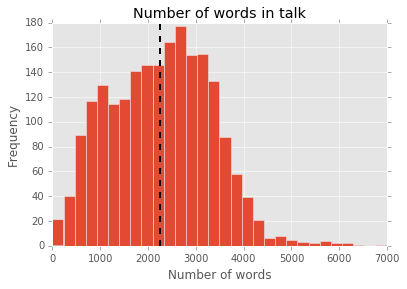

In [7]:
lengths = [len(x) for x  in X]
plt.hist(lengths, bins=30)
plt.axvline(np.mean(lengths), linestyle='--', c='k', linewidth=2)
plt.title('Number of words in talk')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

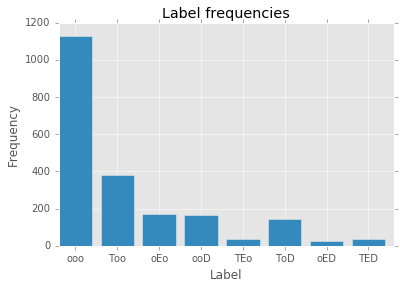

In [8]:
width = 0.8
n_labels = len(labels)
plt.bar(np.arange(n_labels), np.histogram(y, bins=n_labels)[0], width=width)
ax = plt.gca()
ax.set_xticks(np.arange(n_labels) + width / 2)
ax.set_xticklabels(labels)
plt.title('Label frequencies')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [9]:
class Model():
    '''
    Model consisting of an embedding layer and 1 hidden layer
    '''
    def __init__(self, input_shape=[None, None], dropout=0.5):
        self.dropout = dropout
        self.input_tensor = tf.placeholder(tf.int32, shape=input_shape)
        self.target_tensor = tf.placeholder(tf.int64, shape=input_shape[0])
        self.define_model()
        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())
        
        
    def define_model(self):
        # Variables
        self.W_e = tf.Variable(tf.random_uniform([V+1, E], -1, 1))
        self.W_h = tf.Variable(tf.truncated_normal([E, H], stddev=0.1))
        self.b_h = tf.Variable(tf.zeros([H]))
        self.W_v = tf.Variable(tf.truncated_normal([H, O], stddev=0.1))
        self.b_v = tf.Variable(tf.zeros([O]))
        self.keep_prob = tf.placeholder(tf.float32)

        # Computational Graph
        self.x = tf.reduce_mean(tf.nn.embedding_lookup(self.W_e, self.input_tensor), axis=1)
        self.h = tf.nn.dropout(tf.nn.tanh(tf.matmul(self.x, self.W_h) + self.b_h), self.keep_prob)
        self.u = tf.matmul(self.h, self.W_v) + self.b_v
        
        # Metrics and updates
        cent = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.target_tensor, logits=self.u)
        self.cost = tf.reduce_mean(cent)

        self.train_step = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(self.cost)

        self.prediction = tf.nn.softmax(self.u)
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.prediction, 1), self.target_tensor), tf.float32))
        
    def train(self, X_train, y_train, X_val, y_val, n_epochs=N_EPOCHS, print_every=1):
        X_val = sample_words(X_val)
        for epoch in range(n_epochs):
            train_order = np.random.permutation(len(X_train))
            train_order = np.hstack([train_order, train_order])
            losses = []
            accs = []
            for b in range(0, len(X_train), BATCH_SIZE):
                batch_idx = train_order[b:b+BATCH_SIZE]
                X_batch = X_train[batch_idx]
                y_batch = y_train[batch_idx]
                # Sample N_WORDS from each talk
                X_batch = sample_words(X_batch)
                feed_dict = feed_dict={self.input_tensor:X_batch, self.target_tensor: y_batch, self.keep_prob: self.dropout}
                preds, acc, loss, _ = self.session.run([self.prediction, self.accuracy, self.cost, self.train_step], feed_dict)
                losses.append(loss)
                accs.append(acc)
            
            if epoch % print_every == 0:
                # We can do validation in 1 batch
                feed_dict = feed_dict={self.input_tensor:X_val, self.target_tensor: y_val, self.keep_prob: 1.}
                preds, acc, loss, = self.session.run([self.prediction, self.accuracy, self.cost], feed_dict)
                print('Epoch %d\ttrain_loss=%.3f\ttrain_accuracy=%.2f\tval_loss=%.3f\tval_accuracy=%.2f' % (
                    epoch, np.mean(losses), np.mean(accs), loss, acc
                ))
            
    def predict(self, X):
        preds = self.session.run(self.prediction, feed_dict={self.input_tensor: X, self.keep_prob:1.})
        return preds

In [10]:
model = Model()

In [11]:
model.train(np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), print_every=5)

Epoch 0	train_loss=1.884	train_accuracy=0.50	val_loss=1.885	val_accuracy=0.34
Epoch 5	train_loss=1.273	train_accuracy=0.61	val_loss=1.976	val_accuracy=0.34
Epoch 10	train_loss=1.224	train_accuracy=0.61	val_loss=1.957	val_accuracy=0.34
Epoch 15	train_loss=1.133	train_accuracy=0.61	val_loss=1.831	val_accuracy=0.35
Epoch 20	train_loss=1.038	train_accuracy=0.63	val_loss=1.823	val_accuracy=0.36
Epoch 25	train_loss=0.953	train_accuracy=0.67	val_loss=1.806	val_accuracy=0.38
Epoch 30	train_loss=0.867	train_accuracy=0.70	val_loss=1.757	val_accuracy=0.39
Epoch 35	train_loss=0.794	train_accuracy=0.73	val_loss=1.816	val_accuracy=0.38
Epoch 40	train_loss=0.735	train_accuracy=0.75	val_loss=1.871	val_accuracy=0.38
Epoch 45	train_loss=0.694	train_accuracy=0.75	val_loss=1.929	val_accuracy=0.40
Epoch 50	train_loss=0.630	train_accuracy=0.78	val_loss=1.947	val_accuracy=0.41
Epoch 55	train_loss=0.585	train_accuracy=0.80	val_loss=2.075	val_accuracy=0.40
Epoch 60	train_loss=0.546	train_accuracy=0.82	val_loss

In [12]:
# For the test data, we can feed them in one by one to average all words
preds = [np.argmax(model.predict(np.expand_dims(np.array(x), 0))[0]) for x in X_test]
print(classification_report(y_test, preds, target_names=labels))
print('accuracy', accuracy_score(y_test, preds))

             precision    recall  f1-score   support

        ooo       0.45      0.95      0.61        73
        Too       0.44      0.45      0.44        56
        oEo       0.33      0.05      0.09        41
        ooD       0.50      0.52      0.51        27
        TEo       0.00      0.00      0.00         8
        ToD       0.40      0.07      0.12        28
        oED       0.00      0.00      0.00         6
        TED       0.00      0.00      0.00        11

avg / total       0.38      0.45      0.36       250

accuracy 0.448


d:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
embeddings = model.W_e.eval(model.session)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE()
proj_2d = tsne.fit_transform(embeddings)

In [ ]:
words_list = [x[1] for x in sorted(idx2word.items(), key=lambda x: x[0])]
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=proj_2d[:,0],
                                    x2=proj_2d[:,1],
                                    names=words_list))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)